<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher_New/blob/main/FineTunedDETR_(final_version_2024_06_08).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FineTunedDETR (final_version_2023/09/23)

In [ ]:
# まず、使用するライブラリを呼び出す。
from google.colab import drive
import os
import shutil
import cv2
import numpy as np

In [ ]:
# Google Driveを呼び出す。
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# xpFilesAnnotationのコピーを作成する。
shutil.copytree('/content/drive/MyDrive/XPFiles/xpFilesAnnotation','/content/xpFilesAnnotation_copy')

'/content/xpFilesAnnotation_copy'

In [ ]:
#PyTorchとそのビジョン関連のライブラリ（TorchVision）をインポート
import torch, torchvision
#現在使用しているPyTorchのバージョンと、CUDAが利用可能かどうかを表示
print(torch.__version__, torch.cuda.is_available())
#勾配計算を無効化（False）。通常、モデルを評価モードで使用するときに行う。勾配計算を無効にすることで、推論が速くなり、メモリ使用量も減少
torch.set_grad_enabled(False);

2.3.0+cu121 True


#####DETRの入力と出力に対する前処理と後処理

In [ ]:
#画像データの前処理（リサイズ、正規化など）のため、TorchVisionライブラリのtransformsモジュールをTという名前でインポート
import torchvision.transforms as T
#複数の画像変換を組み合わせて一つの変換を作る
transform = T.Compose([
    T.Resize(800),#画像の短い辺を800ピクセルにリサイズ
    T.ToTensor(),#PILイメージまたはNumPy ndarrayをPyTorchのテンソルに変換
    #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#画像の各色チャンネルを平均と標準偏差で正規化
])
#バウンディングボックスの形式を(cx, cy, w, h)から(x_min, y_min, x_max, y_max)に変換する関数を定義
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)#入力テンソルxから中心の座標(cx, cy)と幅・高さ(w, h)を抽出
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]#新しい座標形式に変換する計算
    return torch.stack(b, dim=1)#計算された座標をテンソルとしてスタック
#出力されたバウンディングボックスを画像の実際のサイズにリスケールする関数を定義
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size#画像の実際の幅と高さを抽出
    b = box_cxcywh_to_xyxy(out_bbox)#先に定義したbox_cxcywh_to_xyxy関数を用いて、バウンディングボックスの座標形式を変換
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)#バウンディングボックスの座標を画像の実際のサイズにスケーリング
    return b#スケーリングされたバウンディングボックスの座標を返している

#####モデル（おそらくDETR）からの出力をフィルタリングし、その結果を返す関数を定義
信頼度が閾値以上のバウンディングボックスと、それに対応するクラスの確率を返している。

In [ ]:
#モデルの出力と信頼度の閾値(デフォルトでは0.7)を引数とする関数を定義
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  #モデル出力から'pred_logits'を取り出し、softmax関数を適用して確率に変換。その後、最後のクラス（通常は背景クラス）を除いたものを取得
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  #各バウンディングボックスに対して、最も高い確率（最大値）が閾値より大きいかどうかをチェック(信頼度が閾値より高いバウンディングボックスだけをフィルタリング)
  keep = probas.max(-1).values > threshold
  #信頼度が閾値より高いバウンディングボックスに対応するクラスの予測確率だけを保存
  probas_to_keep = probas[keep]
  #フィルタリングされたバウンディングボックスの座標を元の画像サイズにリスケール
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  #フィルタリングされたバウンディングボックスとその確率を戻り値として返す。
  return probas_to_keep, bboxes_scaled

In [ ]:
# COCOデータセットに存在するオブジェクトのクラス名をPythonのリストとして定義
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# 可視化に使用する色をRGB形式で指定したリスト
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

#####DETRの出力（バウンディングボックスとその確率）を元の画像に重ねて可視化する

In [ ]:
#グラフや画像を描画するため、matplotlibをインポート
import matplotlib.pyplot as plt
#引数にPIL形式の画像(pil_img)、確率(prob)、バウンディングボックス(boxes)を持つ関数を定義
def plot_results(pil_img, prob=None, boxes=None):
  #描画する図のサイズを指定
    plt.figure(figsize=(16,10))
    #PIL形式の画像を表示
    plt.imshow(pil_img)
    #軸を取得
    ax = plt.gca()
    #多数のバウンディングボックスを色分けするため、色のリストを100倍に拡張。
    colors = COLORS * 100
    #probとboxesがNoneでない場合に、次の処理を行う。
    if prob is not None and boxes is not None:
      #各バウンディングボックスとその確率、色についてループを回す。
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        #バウンディングボックスを描画
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()#最も確率が高いクラスのインデックスを取得
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'#描画するテキストを設定
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5)) #バウンディングボックスの左上にテキストを描画
    plt.axis('off') #軸を非表示に
    plt.show() #描画した図を表示

#####GitHubからカスタムデータセットに適応したDETRのフォークをクローンする操作

In [ ]:
first_class_index = 0

In [ ]:
#Google Colabでの作業ディレクトリを/content/に移動。
%cd /content/
#もし以前にdetrという名前のフォルダがあれば、それを削除
!rm -rf detr
#GitHubからカスタムバージョンのDETRコードをクローン
!rm -rf detr
!git clone https://github.com/woctezuma/detr.git #これを実行すると、"detr"なるディレクトリが出現する
#クローンしたdetrディレクトリに移動
%cd detr/
#finetuneという名前のGitブランチにチェックアウト。このブランチには微調整用のコードが含まれている
!git checkout finetune

/content
Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 265 (delta 4), reused 6 (delta 3), pack-reused 254
Receiving objects: 100% (265/265), 325.43 KiB | 29.58 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/detr
Already on 'finetune'
Your branch is up to date with 'origin/finetune'.


######DETRをダウンロードし、ファインチューニング用に前処理
後で自分のデータセットに適したヘッドに置き換えるため、学習済みの重みをロードし、クラス分類のヘッドを削除。

In [ ]:
#前学習済みのDETRモデルのパラメータをダウンロード
checkpoint=torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
    map_location='cpu',
    check_hash=True)
#クラス分類の頭部（head）を削除。これにより、新しいクラスに対してモデルを微調整できるようになる。
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]
#クラス分類の頭部を削除した後のモデルの状態を保存
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100%|██████████| 159M/159M [00:00<00:00, 216MB/s]


In [ ]:
#ディレクトリ"detr/"から"/content/"に移動
%cd /content/

/content


#####ファイルの格納
作成したファイルをデータロードに使用するディレクトリを作成しそこに格納する。

In [ ]:
#dataが格納された、/content/VIA2COCO/のpathを指定。
data_path='/content/xpFilesAnnotation_copy/'

# 以下はデータ移動と可視化に関するコード
#アノテーション（注釈）データを格納する場所、/content/data/custom/annotations/ディレクトリを作成。
!mkdir -p /content/data/custom/annotations/
#訓練用のJSONファイル（COCO形式）を新しく作成したannotationsディレクトリに移動
!mv /content/xpFilesAnnotation_copy/train/custom_train.json /content/data/custom/annotations/custom_train.json
#バリデーション用のJSONファイルも同様にannotationsディレクトリに移動
!mv /content/xpFilesAnnotation_copy/val/custom_val.json /content/data/custom/annotations/custom_val.json
#訓練画像を格納するディレクトリを作成
!mkdir -p /content/data/custom/train2017/
#訓練用の画像ファイルをtrain2017ディレクトリに移動。
!mv /content/xpFilesAnnotation_copy/train/*.png /content/data/custom/train2017/
#バリデーション画像を格納するディレクトリを作成。
!mkdir -p /content/data/custom/val2017/
#バリデーション用の画像ファイルをval2017ディレクトリに移動
!mv /content/xpFilesAnnotation_copy/val/*.png /content/data/custom/val2017/

######データロードの確認
pycocotoolsを使って、COCO形式のアノテーションが正しく読み込まれているか確認する。また、ランダムに一つの画像を選び、そのアノテーション（ここではバルーン）を可視化する。

In [ ]:
#Jupyter NotebookでMatplotlibをインライン表示にするためのマジックコマンド
%matplotlib inline
#pycocotoolsからCOCOクラスをcocoとしてインポート。COCOデータセット用のAPI
import pycocotools.coco as coco
#COCOクラスを直接インポート。
from pycocotools.coco import COCO
#NumPyをnpとしてインポート。
import numpy as np
#skimageのioモジュールをioとしてインポート。画像の入出力に使用。
import skimage.io as io
#Matplotlibのpyplotをpltとしてインポート。グラフ描画に使用。
import matplotlib.pyplot as plt
#Matplotlibに依存するライブラリで、グラフ描画やデータ可視化に使用。
import pylab
# Matplotlibの図のデフォルトサイズを10x8に設定。
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
#カスタムデータセットのディレクトリを指定。
dataDir='/content/data/custom/'
#トレーニングデータの種類を指定。'train2017'はCOCOデータセットの一部。
dataType='train2017'
#アノテーションファイルのパスを作成。
annFile='{}annotations/custom_train.json'.format(dataDir)

In [ ]:
#COCOクラスのインスタンスを作成し、アノテーションファイルを読み込む。
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


######カテゴリ情報の確認
COCOのcategoriesとsupercategoriesを表示する。

In [ ]:
#カテゴリIDを取得し、それに対応するカテゴリ情報をロード。
cats = coco.loadCats(coco.getCatIds())
print(cats)
#各カテゴリオブジェクトからカテゴリ名を抽出。
nms = [cat['name'] for cat in cats]
#カテゴリ名を出力
print('Categories: {}'.format(nms))
#各カテゴリオブジェクトからスーパーカテゴリを抽出し、セットにする。
#nms = set([cat['super_categories'] for cat in cats])
#スーパーカテゴリを出力。
#print('Super-categories: {}'.format(nms))

[{'id': 1, 'name': 'wrist'}, {'id': 2, 'name': 'MCP1st'}, {'id': 3, 'name': 'MCPs'}, {'id': 4, 'name': 'IP'}, {'id': 5, 'name': 'PIPs'}, {'id': 6, 'name': 'DIPs'}]
Categories: ['wrist', 'MCP1st', 'MCPs', 'IP', 'PIPs', 'DIPs']


In [ ]:
#カテゴリIDを取得。
catIds = coco.getCatIds(catNms=['wrist', 'MCP1st', 'MCPs', 'IP', 'PIPs','DIPs']);
#特定のカテゴリIDに対応する画像IDを取得。
imgIds = coco.getImgIds(catIds=catIds);

Image n°110
Image name: /content/data/custom//train2017/046836_1.2.392.200036.9107.307.13572.1357217050100643.121.png


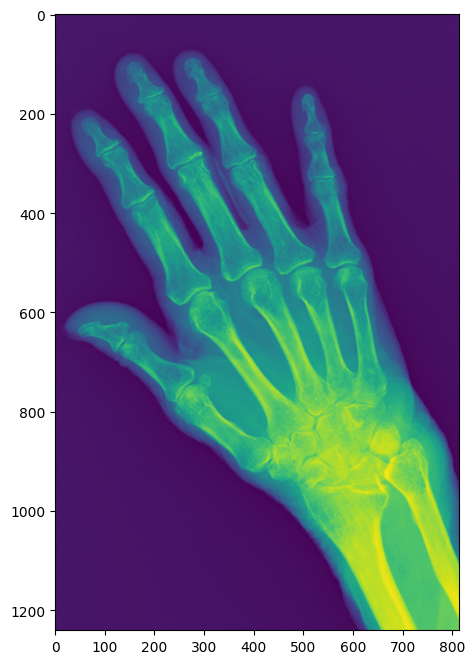

In [ ]:
#ランダムに一つの画像IDを選ぶ。
img_id = imgIds[np.random.randint(0,len(imgIds))]
#選ばれた画像IDを出力。
print('Image n°{}'.format(img_id))
#選ばれた画像IDに対応する画像情報をロード。
img = coco.loadImgs(img_id)[0]
#画像のフルパスを生成
img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
#画像の出力。
print('Image name: {}'.format(img_name))
#画像を読み込み、新しく図を作成して表示。
I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [ ]:
#特定の画像IDとカテゴリIDに対応するアノテーションIDを取得。
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
#取得したアノテーションIDに基づいて、アノテーション情報をロード。
anns = coco.loadAnns(annIds)

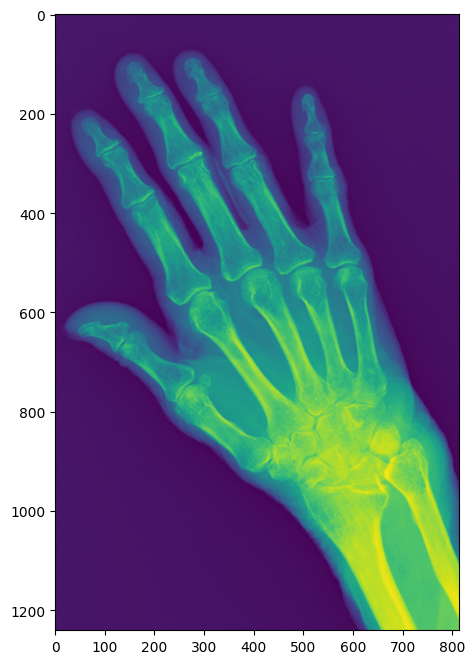

In [ ]:
# load and display instance annotations
plt.imshow(I)#画像を表示
coco.showAnns(anns, draw_bbox=False)#アノテーションを画像上に表示。draw_bbox=Falseなのでここではバウンディングボックスは描画されない。

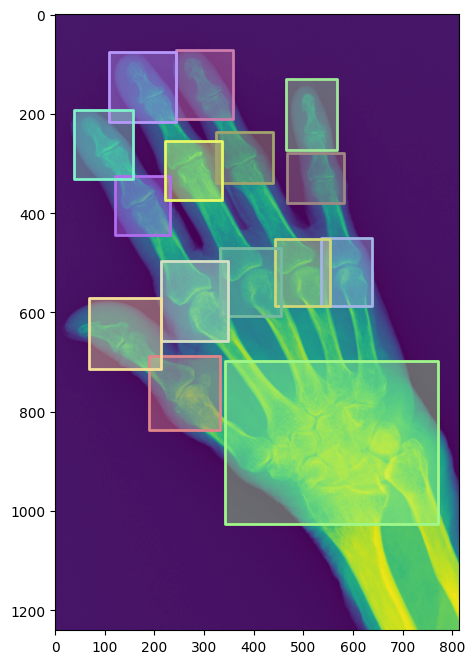

In [ ]:
plt.imshow(I)#同じ画像を再度表示。
coco.showAnns(anns, draw_bbox=True)#今度はバウンディングボックスも含めてアノテーションを表示。

In [ ]:
#first_class_indexが0か1であることを確認。そうでなければエラーを出力。
assert(first_class_index in [0, 1])
if first_class_index == 0:#first_class_indexが0の場合。
  num_classes = 7 #クラス数を1に設定。
  finetuned_classes = [
      'N/A', 'wrist', 'MCP1st', 'MCPs', 'IP', 'PIPs','DIPs',
  ]#ファインチューニングするクラスを設定。
else:#first_class_indexが1の場合。
  num_classes = 7#クラス数を2に設定。
  finetuned_classes = [
      'N/A', 'wrist', 'MCP1st', 'MCPs', 'IP', 'PIPs','DIPs',
  ]#ファインチューニングするクラスを'設定。

#各変数の値を出力。
print('First class index: {}'.format(first_class_index))
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 7
Fine-tuned classes: ['N/A', 'wrist', 'MCP1st', 'MCPs', 'IP', 'PIPs', 'DIPs']


In [ ]:
#カレントディレクトリを/content/detr/に変更。
%cd /content/detr/

/content/detr


In [ ]:
#DETRのメインスクリプトを実行。学習の設定はコマンドライン引数で指定。
!python main.py \
  --dataset_file "custom" \
  --coco_path "/content/data/custom/" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10

Not using distributed mode
git:
  sha: e891373a8cab93d3719afb0acff28de94c6dc6a3, status: clean, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=10, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=7, dataset_file='custom', coco_path='/content/data/custom/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The param

In [ ]:
#関数を用いて、学習ログを表示。具体的にはロス、mAP、各種エラー等をプロット。
#from detr.util.plot_utils import plot_logs
from pathlib import Path
log_directory = [Path('outputs/')]

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

def calculate_map(coco_eval_bbox):
    if isinstance(coco_eval_bbox, list):
        return np.mean(coco_eval_bbox)
    return float('nan')

def update_log_file(log_path):
    log_file_path = Path(log_path)

    # ファイルが存在することを確認
    if not log_file_path.exists():
        print(f"ログファイルが見つかりません: {log_file_path}")
        return

    # ファイルを読み込み
    df = pd.read_json(log_file_path, lines=True)

    # mAPを計算して追加
    if 'test_coco_eval_bbox' in df.columns:
        df['mAP'] = df['test_coco_eval_bbox'].apply(calculate_map)

    # test_coco_eval_bbox列を削除
    df = df.drop(columns=['test_coco_eval_bbox'])

    # 更新されたデータフレームをファイルに書き戻す
    df.to_json(log_file_path, orient='records', lines=True)

    # 更新されたファイルの内容を表示
    print("更新されたログファイルの内容（最初の5行）:")
    print(df.head())

# 例として、log.txtファイルへのパスを指定
log_path = '/content/detr/outputs/log.txt'
update_log_file(log_path)


更新されたログファイルの内容（最初の5行）:
   train_lr  train_class_error  train_loss  train_loss_ce  train_loss_bbox  \
0    0.0001          16.399955    7.978561       0.438609         0.275331   
1    0.0001           2.279792    4.411613       0.084344         0.181112   
2    0.0001           1.760686    3.914345       0.057408         0.167349   
3    0.0001           1.126051    3.666889       0.039255         0.159394   
4    0.0001           1.151498    3.589650       0.042241         0.155526   

   train_loss_giou  train_loss_ce_0  train_loss_bbox_0  train_loss_giou_0  \
0         0.522102         0.693790           0.288971           0.546281   
1         0.396674         0.298196           0.197868           0.432063   
2         0.367341         0.220950           0.188243           0.410769   
3         0.355636         0.198471           0.175920           0.394788   
4         0.345959         0.195095           0.175528           0.389383   

   train_loss_ce_1  ...  test_loss_bbox_3_uns

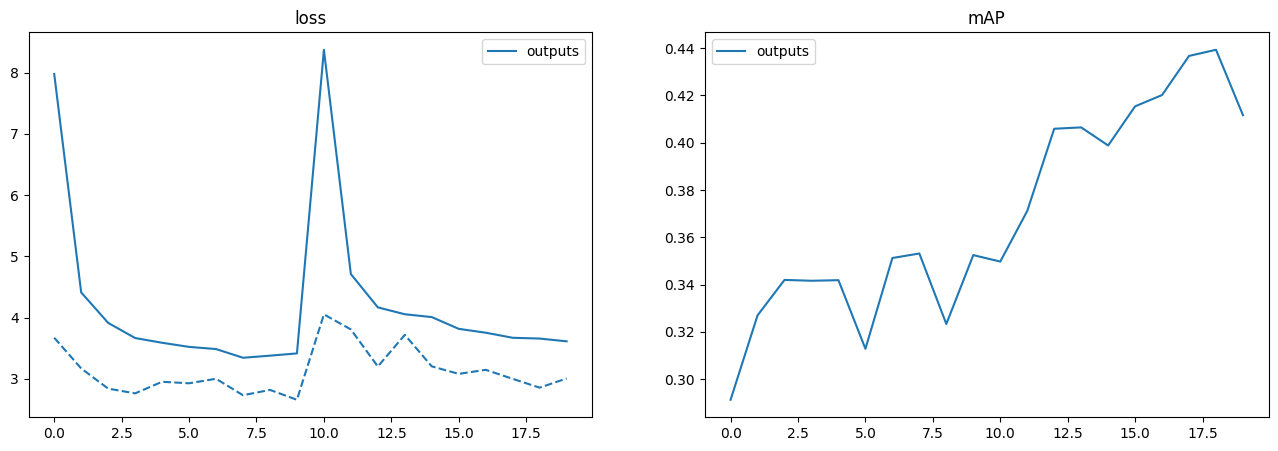

In [ ]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

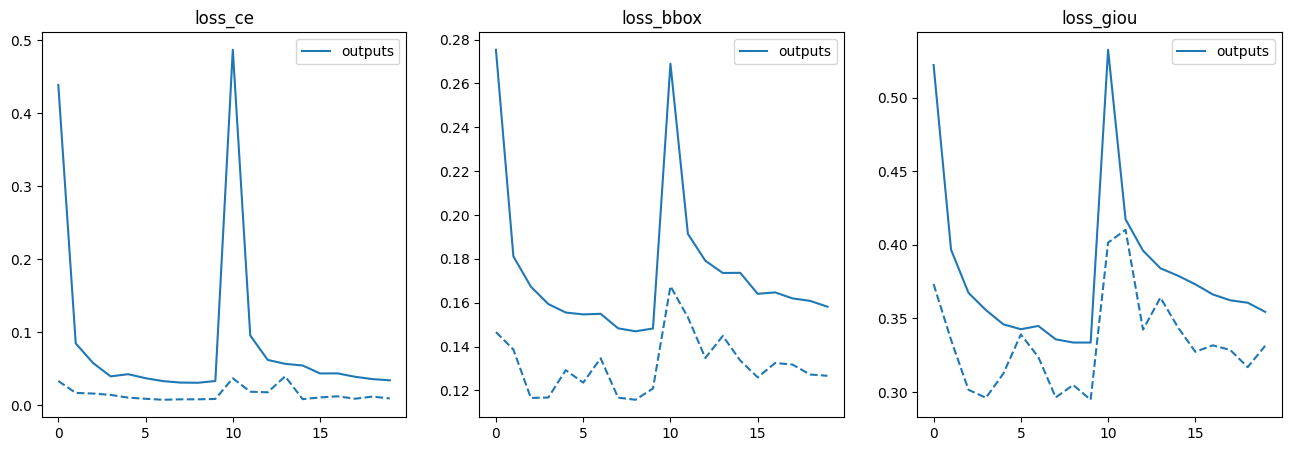

In [ ]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

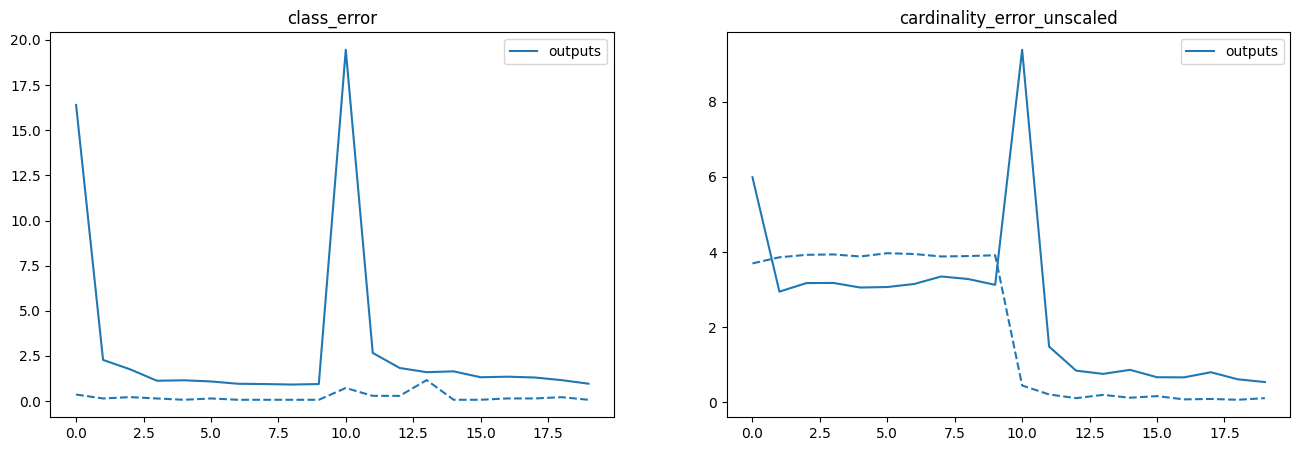

In [ ]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)

In [ ]:
#この行でDETRモデル（ResNet-50をバックボーンとするもの）を読み込む。このモデルは事前学習されていない（pretrained=False）ので、ランダムな重みで初期化される。
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)
#訓練が完了した後に保存されるチェックポイントファイルを読み込む。
checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')
#チェックポイントからモデルの状態を復元。strict=Falseはモデルとチェックポイントの層が完全に一致していなくても読み込むことを意味する。
model.load_state_dict(checkpoint['model'],
                      strict=False)
#モデルを評価モードに切り替え。これは、DropoutやBatch Normalizationなどの層が評価モードになることを意味する。
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#####確率とバウンディングボックスを描画する関数を宣言
関数'plot_finetuned_results'は、引数としてpil_omg, prob, bokesを使用する。

In [ ]:
#指定された画像（pil_img）上に確率とバウンディングボックス（probとboxes）を描画する関数を宣言。
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    #大きさが16x11の図をプロット
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    #ボックスもプローブもない場合の処理は下の通り
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

#####推論の結果を可視化する関数を宣言
指定され画像（my_image）とモデル（my_model）を使って推論

訓練画像の表示

検証用画像の表示

In [ ]:
def run_workflow(my_image, my_model):
    img = transform(my_image).unsqueeze(0)
    # グレースケール画像をRGBに変換
    if img.shape[1] == 1:
        img = img.repeat(1, 3, 1, 1)

    outputs = my_model(img)
    for threshold in [0.9, 0.7]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)
        plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled)

In [ ]:
from torchvision import transforms

def run_workflow(my_image, my_model):
    # 画像がグレースケールの場合はRGBに変換
    if my_image.mode == 'L':
        my_image = my_image.convert('RGB')

    # 変換を適用
    img = transform(my_image).unsqueeze(0)

    outputs = my_model(img)
    for threshold in [0.9, 0.7]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)
        plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled)

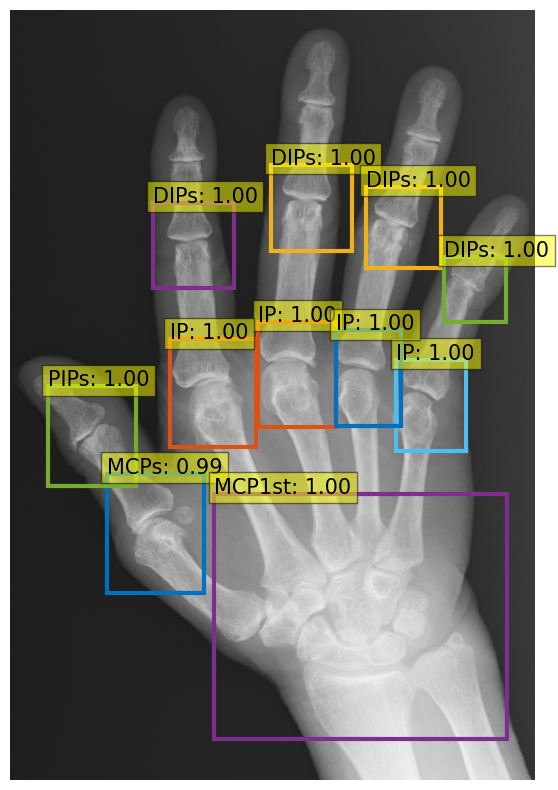

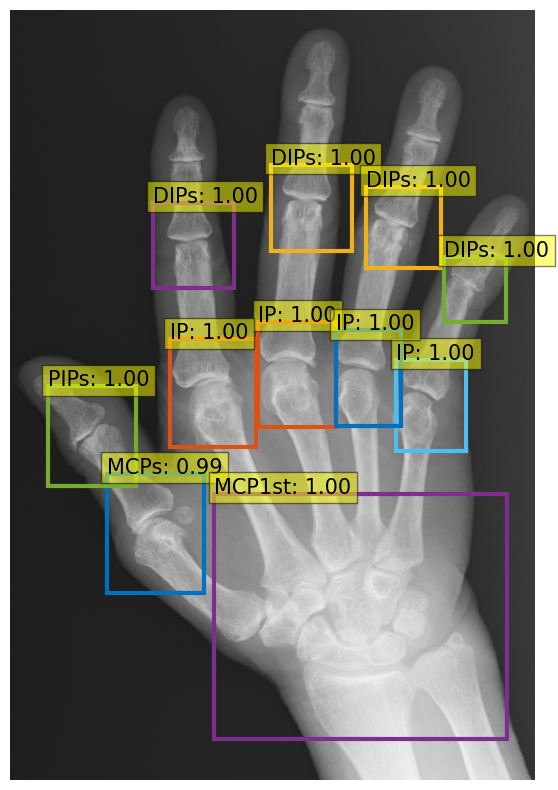

In [ ]:
from PIL import Image
img_name = '/content/data/custom/train2017/010476_1.2.392.200036.9107.307.13535.1353519060616846.121.png'
im = Image.open(img_name)
run_workflow(im, model)

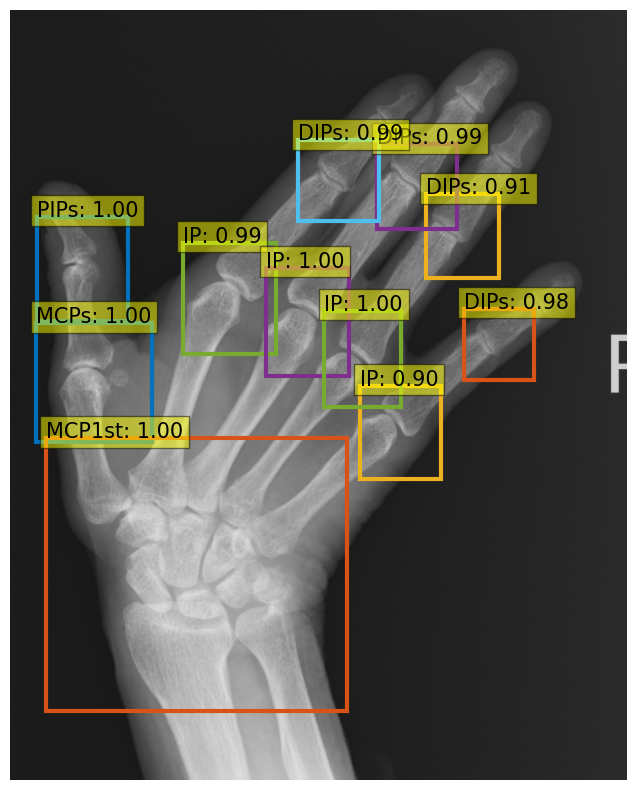

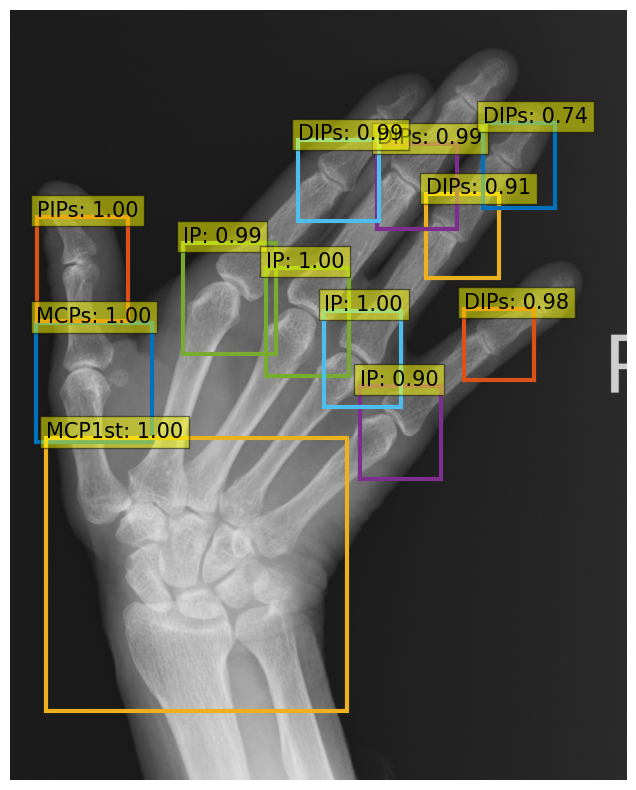

In [ ]:
from PIL import Image

img_name = '/content/data/custom/train2017/000400_1.2.392.200036.9107.307.13574.1357417053109736.121.png'
im = Image.open(img_name)
run_workflow(im, model)

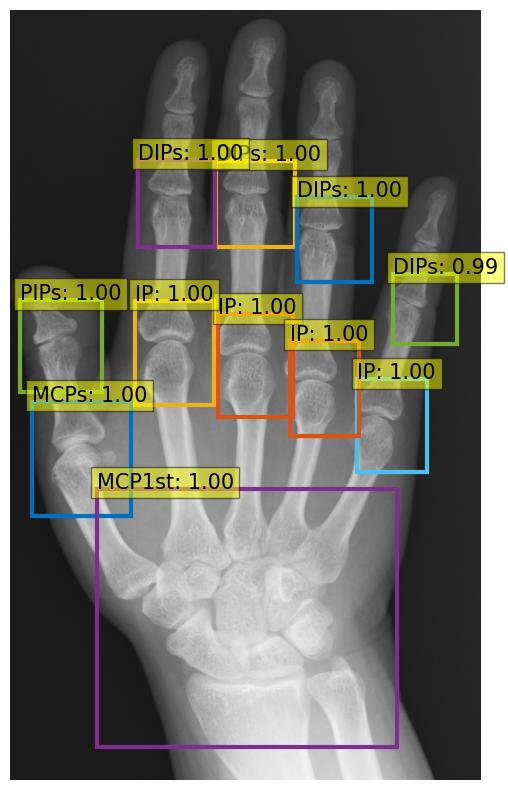

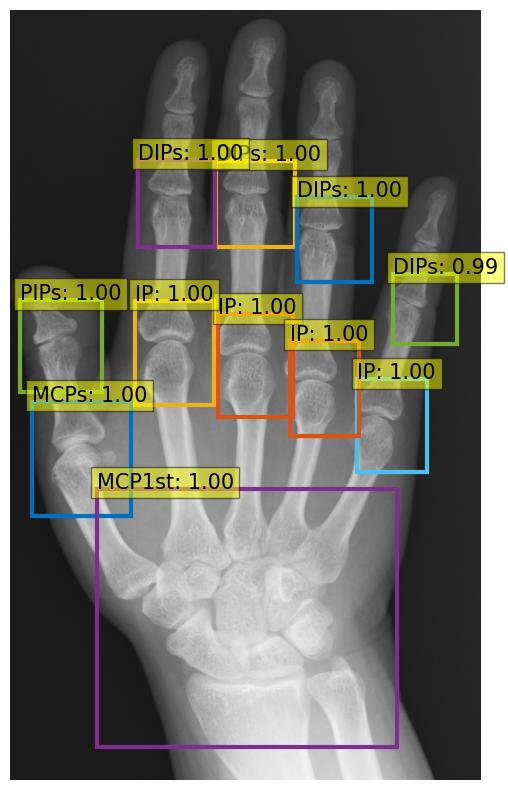

In [ ]:
img_name = '/content/data/custom/train2017/002316_1.2.392.200036.9107.307.13547.1354716010510368.121.png'
im = Image.open(img_name)
run_workflow(im, model)

In [ ]:
# 必要なライブラリのインポート
from PIL import Image
import os
from PIL import ImageDraw
import json

In [ ]:
base_dir = "/content/drive/MyDrive/xpFile_bbox_DETR"
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [ ]:
with open('/content/data/custom/annotations/custom_train.json', 'r') as file:
    train_labels_json = json.load(file)
# 同様に、validation用のJSONファイルも処理する
with open('/content/data/custom/annotations/custom_val.json', 'r') as file:
    val_labels_json = json.load(file)
# JSONデータを合体させます
labels_json = {
    "images": train_labels_json["images"] + val_labels_json["images"],
    "annotations": train_labels_json["annotations"] + val_labels_json["annotations"],
    "categories": train_labels_json["categories"] }

In [ ]:
import glob
train_images_path_list = glob.glob('/content/data/custom/train2017/*.png')  # train2017の.png画像の場合
val_images_path_list = glob.glob('/content/data/custom/val2017/*.png')  # val2017の.png画像の場合
images_path_list = train_images_path_list + val_images_path_list
# 画像のファイル名とパスの辞書を作成します。
images_path_dict = {os.path.basename(path): path for path in images_path_list}

In [ ]:
# bboxをクロップして保存する関数
def save_bbox_image(image_item, labels_json):
    # ファイル名から必要な部分を取得
    file_name = image_item["file_name"]
    #dir_name = file_name[:6] + "_" + file_name[43:49]
    dir_name = os.path.splitext(os.path.basename(file_name))[0]
    dir_path = os.path.join(base_dir, dir_name)

    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    classes = ['wrist', 'MCP1st', 'MCPs', 'IP', 'PIPs','DIPs']
    for class_name in classes:
        class_dir = os.path.join(dir_path, class_name)
        if not os.path.exists(class_dir):
            os.mkdir(class_dir)
    ann_image_dir = os.path.join(dir_path, "annotationImage")
    if not os.path.exists(ann_image_dir):
        os.mkdir(ann_image_dir)
    image_path = images_path_dict.get(image_item["file_name"])
    #image_path = image_item["file_name"]
    with Image.open(image_path) as img:
        drawed_img = img.copy()
        draw = ImageDraw.Draw(drawed_img)

        for annotation_item in labels_json["annotations"]:
            if annotation_item["image_id"] == image_item["id"]:
                class_id = annotation_item["category_id"]
                class_name = [category["name"] for category in labels_json["categories"] if category["id"] == class_id][0]
                bbox = annotation_item["bbox"]

                cropped_img = img.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
                cropped_img_name = f"{dir_name}_{class_name}_{annotation_item['id']}.png"
                cropped_img_path = os.path.join(dir_path, class_name, cropped_img_name)
                cropped_img.save(cropped_img_path)

                # bboxを描画
                draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], outline='red', width=2)

        ann_image_name = f"{dir_name}_annotation.png"
        ann_image_path = os.path.join(ann_image_dir, ann_image_name)
        drawed_img.save(ann_image_path)

# 各画像に対して関数を実行
for image_item in labels_json["images"]:
    save_bbox_image(image_item, labels_json)
print("All bbox images saved!")

KeyboardInterrupt: 

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model


def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser


def main(args):
    utils.init_distributed_mode(args)
    print("git:\n  {}\n".format(utils.get_sha()))

    if args.frozen_weights is not None:
        assert args.masks, "Frozen training is meant for segmentation only"
    print(args)

    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model, criterion, postprocessors = build_model(args)
    model.to(device)

    model_without_ddp = model
    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        model_without_ddp = model.module
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('number of params:', n_parameters)

    param_dicts = [
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": args.lr_backbone,
        },
    ]
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                  weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

    dataset_train = build_dataset(image_set='train', args=args)
    dataset_val = build_dataset(image_set='val', args=args)

    if args.distributed:
        sampler_train = DistributedSampler(dataset_train)
        sampler_val = DistributedSampler(dataset_val, shuffle=False)
    else:
        sampler_train = torch.utils.data.RandomSampler(dataset_train)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True)

    data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                   collate_fn=utils.collate_fn, num_workers=args.num_workers)
    data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

    if args.dataset_file == "coco_panoptic":
        # We also evaluate AP during panoptic training, on original coco DS
        coco_val = datasets.coco.build("val", args)
        base_ds = get_coco_api_from_dataset(coco_val)
    else:
        base_ds = get_coco_api_from_dataset(dataset_val)

    if args.frozen_weights is not None:
        checkpoint = torch.load(args.frozen_weights, map_location='cpu')
        model_without_ddp.detr.load_state_dict(checkpoint['model'])

    output_dir = Path(args.output_dir)
    if args.resume:
        if args.resume.startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                args.resume, map_location='cpu', check_hash=True)
        else:
            checkpoint = torch.load(args.resume, map_location='cpu')
        model_without_ddp.load_state_dict(checkpoint['model'])
        if not args.eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            args.start_epoch = checkpoint['epoch'] + 1

    if args.eval:
        test_stats, coco_evaluator = evaluate(model, criterion, postprocessors,
                                              data_loader_val, base_ds, device, args.output_dir)
        if args.output_dir:
            utils.save_on_master(coco_evaluator.coco_eval["bbox"].eval, output_dir / "eval.pth")
        return

    print("Start training")
    start_time = time.time()
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            sampler_train.set_epoch(epoch)
        train_stats = train_one_epoch(
            model, criterion, data_loader_train, optimizer, device, epoch,
            args.clip_max_norm)
        lr_scheduler.step()
        if args.output_dir:
            checkpoint_paths = [output_dir / 'checkpoint.pth']
            # extra checkpoint before LR drop and every 100 epochs
            if (epoch + 1) % args.lr_drop == 0 or (epoch + 1) % 100 == 0:
                checkpoint_paths.append(output_dir / f'checkpoint{epoch:04}.pth')
            for checkpoint_path in checkpoint_paths:
                utils.save_on_master({
                    'model': model_without_ddp.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'args': args,
                }, checkpoint_path)

        test_stats, coco_evaluator = evaluate(
            model, criterion, postprocessors, data_loader_val, base_ds, device, args.output_dir
        )

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     **{f'test_{k}': v for k, v in test_stats.items()},
                     'epoch': epoch,
                     'n_parameters': n_parameters}

        if args.output_dir and utils.is_main_process():
            with (output_dir / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")

            # for evaluation logs
            if coco_evaluator is not None:
                (output_dir / 'eval').mkdir(exist_ok=True)
                if "bbox" in coco_evaluator.coco_eval:
                    filenames = ['latest.pth']
                    if epoch % 50 == 0:
                        filenames.append(f'{epoch:03}.pth')
                    for name in filenames:
                        torch.save(coco_evaluator.coco_eval["bbox"].eval,
                                   output_dir / "eval" / name)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))


if __name__ == '__main__':
    parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
    args = parser.parse_args()
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    main(args)

In [ ]:
"""
Plotting utilities to visualize training logs.
"""
# トレーニングログを可視化するためのプロットユーティリティ

import torch  # PyTorchライブラリをインポート
import pandas as pd  # Pandasライブラリをインポート、データ解析用
import numpy as np  # NumPyライブラリをインポート、数値計算用
import seaborn as sns  # Seabornライブラリをインポート、データビジュアライゼーション用
import matplotlib.pyplot as plt  # Matplotlibのpyplotモジュールをインポート、プロット作成用

from pathlib import Path, PurePath  # PathlibモジュールのPathとPurePathクラスをインポート、ファイルシステムのパス操作用

def plot_logs(logs, fields=('class_error', 'loss_bbox_unscaled', 'mAP'), ewm_col=0, log_name='log.txt'):
    '''
    Function to plot specific fields from training log(s). Plots both training and test results.

    :: Inputs - logs = list containing Path objects, each pointing to individual dir with a log file
              - fields = which results to plot from each log file - plots both training and test for each field.
              - ewm_col = optional, which column to use as the exponential weighted smoothing of the plots
              - log_name = optional, name of log file if different than default 'log.txt'.

    :: Outputs - matplotlib plots of results in fields, color coded for each log file.
               - solid lines are training results, dashed lines are test results.

    '''
    func_name = "plot_utils.py::plot_logs"  # 関数名を示す文字列。エラーメッセージで使用

    # logsがリストでない場合の処理
    if not isinstance(logs, list):
        if isinstance(logs, PurePath):  # logsがPurePathのインスタンスである場合
            logs = [logs]  # 単一のPathオブジェクトをリストに変換
            print(f"{func_name} info: logs param expects a list argument, converted to list[Path].")
        else:  # logsがリストでもPurePathでもない場合
            raise ValueError(f"{func_name} - invalid argument for logs parameter.\n \
            Expect list[Path] or single Path obj, received {type(logs)}")

    # ディレクトリのチェックとログファイルの存在確認
    for i, dir in enumerate(logs):
        if not isinstance(dir, PurePath):  # 各ディレクトリがPurePathのインスタンスでない場合
            raise ValueError(f"{func_name} - non-Path object in logs argument of {type(dir)}: \n{dir}")
        if not dir.exists():  # ディレクトリが存在しない場合
            raise ValueError(f"{func_name} - invalid directory in logs argument:\n{dir}")
        fn = Path(dir / log_name)  # ログファイルの完全なパスを生成
        if not fn.exists():  # ログファイルが存在しない場合
            print(f"-> missing {log_name}.  Have you gotten to Epoch 1 in training?")
            print(f"--> full path of missing log file: {fn}")
            return  # 関数を終了

    # 各ログファイルをJSON形式で読み込み、Pandasデータフレームに変換
    dfs = [pd.read_json(Path(p) / log_name, lines=True) for p in logs]

    # フィールド数に応じたカラム数でプロットを準備し、16×5インチの図を作成
    fig, axs = plt.subplots(ncols=len(fields), figsize=(16, 5))

    # データフレームと色のペアをループ
    for df, color in zip(dfs, sns.color_palette(n_colors=len(logs))):
        for j, field in enumerate(fields):  # 各フィールドについてループ
            if field == 'mAP':  # フィールドがmAPの場合
                coco_eval = pd.DataFrame(
                    np.stack(df.test_coco_eval_bbox.dropna().values)[:, 1]
                ).ewm(com=ewm_col).mean()  # test_coco_eval_bboxのデータを処理し、指数加重移動平均を計算
                axs[j].plot(coco_eval, c=color)  # coco_evalをプロット
            else:  # その他のフィールドの場合
                df.interpolate().ewm(com=ewm_col).mean().plot(
                    y=[f'train_{field}', f'test_{field}'],
                    ax=axs[j],
                    color=[color] * 2,
                    style=['-', '--']
                )  # データフレームの指定フィールドについて補間を行い、指数加重移動平均を計算し、プロット

    # 各プロット軸とフィールドについてループ
    for ax, field in zip(axs, fields):
        ax.legend([Path(p).name for p in logs])  # プロットの凡例を設定
        ax.set_title(field)  # プロットのタイトルをフィールド名に設定


def plot_precision_recall(files, naming_scheme='iter'):
    if naming_scheme == 'exp_id':  # naming_schemeがexp_idの場合
        names = [f.parts[-3] for f in files]  # ファイル名の3番目の部分を使用して名前を生成
    elif naming_scheme == 'iter':  # naming_schemeがiterの場合
        names = [f.stem for f in files]  # ファイルのステム（拡張子を除いた部分）を使用して名前を生成
    else:  # その他の場合
        raise ValueError(f'not supported {naming_scheme}')  # サポートされていない命名スキームについてエラーメッセージを表示して例外を投げる

    # 2つのカラムでプロットを準備し、16×5インチの図を作成
    fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

    # ファイル、色、名前のペアをループ
    for f, color, name in zip(files, sns.color_palette("Blues", n_colors=len(files)), names):
        data = torch.load(f)  # ファイルからデータを読み込む
        precision = data['precision']  # 精度データを取得
        recall = data['params'].recThrs  # 再現率スレッショルドを取得
        scores = data['scores']  # スコアデータを取得
        precision = precision[0, :, :, 0, -1].mean(1)  # 精度データを処理
        scores = scores[0, :, :, 0, -1].mean(1)  # スコアデータを処理
        prec = precision.mean()  # 平均精度を計算
        rec = data['recall'][0, :, 0, -1].mean()  # 平均再現率を計算
        print(f'{naming_scheme} {name}: mAP@50={prec * 100: 05.1f}, ' +
              f'score={scores.mean():0.3f}, ' +
              f'f1={2 * prec * rec / (prec + rec + 1e-8):0.3f}'
              )  # 結果を出力
        axs[0].plot(recall, precision, c=color)  # 再現率と精度をプロット
        axs[1].plot(recall, scores, c=color)  # 再現率とスコアをプロット

    axs[0].set_title('Precision / Recall')  # 左側のプロットのタイトルを設定
    axs[0].legend(names)  # 左側のプロットの凡例を設定
    axs[1].set_title('Scores / Recall')  # 右側のプロットのタイトルを設定
    axs[1].legend(names)  # 右側のプロットの凡例を設定
    return fig, axs  # 作成した図と軸を返す
